In [17]:
'''
Applications of Alternative Data
另类数据的应用
。具体来说，Twitter 和 StockTwits 数据因其实时性以及对金融讨论和股市活动的关注，被认为是金融工程领域宝贵的另类数据来源。
'''# Load libraries
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import plotly.express as px
import re
import requests
import zipfile

from datetime import datetime, timedelta

In [18]:
'''
。咱先学会：把压缩包解开→找 CSV→拼成大 DataFrame，后面再搞情绪分析、跟股价对比。”
'''
# === 把 tweets.zip 解压到 extracted_tweets 这个破目录里 ===
with zipfile.ZipFile('tweets.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_tweets')

# === 找到内部 tweets 子目录下所有 .csv 文件名 ===
tweets_folder = 'extracted_tweets/tweets'
csv_files = [f for f in os.listdir(tweets_folder) if f.endswith('.csv')]

dfs = []                       # 存每张小表
for csv_file in csv_files:
    file_path = os.path.join(tweets_folder, csv_file)
    df = pd.read_csv(file_path, sep=';')   # 这些 CSV 用 ; 分隔，别写错

    # 有的列叫 full_text，有的叫 text，全改成 tweet_text，一起撸
    if 'full_text' in df.columns:
        df = df.rename(columns={'full_text': 'tweet_text'})
    elif 'text' in df.columns:
        df = df.rename(columns={'text': 'tweet_text'})

    dfs.append(df)

# === 把所有小表纵向拼成一张大表 twitter_df ===
twitter_df = pd.concat(dfs, ignore_index=True)
twitter_df.head()


,id,created_at,tweet_text,sentiment
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,NaN
1,2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...,NaN
2,3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...,NaN
3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,NaN
4,5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...,NaN


In [19]:
'''
🕒 1.2 时区调整（华尔街时间校准）
核心操作：UTC时间 → 纽约时间（带夏令时自动切换）

暴论解析：

+00:00就是金融数据的"格林威治吊丝时间"——全球标准但没人用

纽约时间才是市场脉搏：

开盘时间（09:30-16:00 ET）是推文核爆期

夏令时切换时（3月/11月）自动调时，防止数据断片

"不转时区分析推特？等于用北京时间炒美股——找死！"
'''
twitter_df['created_at'] = pd.to_datetime(twitter_df['created_at']).dt.tz_convert('America/New_York')
twitter_df

,id,created_at,tweet_text,sentiment
0,1,2020-04-09 19:59:51-04:00,@KennyDegu very very little volume. With $10T ...,NaN
1,2,2020-04-09 19:58:55-04:00,#ES_F achieved Target 2780 closing above 50% #...,NaN
2,3,2020-04-09 19:58:52-04:00,RT @KimbleCharting: Silver/Gold indicator crea...,NaN
3,4,2020-04-09 19:58:27-04:00,@Issaquahfunds Hedged our $MSFT position into ...,NaN
4,5,2020-04-09 19:57:59-04:00,RT @zipillinois: 3 Surprisingly Controversial ...,NaN
...,...,...,...,...
928668,411380,2020-06-04 14:14:57-04:00,"With ad revenues falling, what’s the impact on...",NaN
928669,62318,2020-04-13 22:15:01-04:00,RT @KelvinSCWong: Well another point to add to...,NaN
928670,627230,2020-06-23 10:08:15-04:00,$ITOX working on a contract with a fortune 500...,NaN
928671,890123,2020-07-14 19:18:34-04:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN


In [20]:
'''
血泪真相：

数据类型	数量	价值	风险
转发(retweets_df)	350,752行	监测情绪传染	90%是跟风韭菜
原创(remainder_df)	577,921行	α因子金矿	需人工过滤噪音


"转发就像交易所大厅的噪音——听着热闹实则有毒，真信号藏在原创推文的枪声里！"

在 Twitter 上，“RT”是“retweet”的常用缩写。当用户想与自己的关注者分享他人的推文时，他们可以转发。“RT”是 Twitter 上转发量的关键指标。它用于手动转发、引用转发，并且已成为 Twitter 文化的一部分。通过在推文开头搜索“RT”，我们可以在数据分析中有效地识别转发。

现在，我们将推文集合分成两组：一组是转发推文，一组是原始推文（或其他类型的非转发推文）。以下代码片段获取包含 Twitter 数据的 twitter_df DataFrame，并通过筛选“tweet_text”列将其拆分为两个新的 DataFrame。然后，该代码使用 display() 函数显示 retweets_df 和 remainder_df
'''

# Create a DataFrame containing only retweets
retweets_df = twitter_df[twitter_df['tweet_text'].str.startswith('RT')]

# Create a DataFrame containing tweets that are not retweets
remainder_df = twitter_df[~twitter_df['tweet_text'].str.startswith('RT')]

# Display the DataFrames
print("## Retweets DataFrame:")
print("This DataFrame contains only retweets from the Twitter data.")
display(retweets_df)

print("\n## Remainder DataFrame:")
print("This DataFrame contains tweets that are not retweets.")
display(remainder_df)

## Retweets DataFrame:
This DataFrame contains only retweets from the Twitter data.


,id,created_at,tweet_text,sentiment
2,3,2020-04-09 19:58:52-04:00,RT @KimbleCharting: Silver/Gold indicator crea...,NaN
4,5,2020-04-09 19:57:59-04:00,RT @zipillinois: 3 Surprisingly Controversial ...,NaN
5,6,2020-04-09 19:57:33-04:00,RT @Crypto____World: 🇿🇼ZIMBABWE🇿🇼\n\nCRYPTO NE...,NaN
7,10,2020-04-09 19:57:08-04:00,RT @NorthmanTrader: I repeat: The Fed is reckl...,NaN
9,13,2020-04-09 19:56:58-04:00,RT @TDANetwork: 📽️ #TheWatchList panel assesse...,NaN
...,...,...,...,...
928656,853677,2020-07-09 21:55:41-04:00,RT @MarketRealist: Facebook Ad Boycott: Zucker...,NaN
928659,933161,2020-07-16 09:08:58-04:00,RT @MarkNewtonCMT: $IHI Ishares Medical Dvcs E...,NaN
928663,580427,2020-06-19 13:57:42-04:00,RT @HedgehogTrader: HHT's Venture/Microcap Sto...,NaN
928667,592492,2020-06-20 16:34:07-04:00,"RT @smtraderCA: ""Is A Big Moving Coming?"" for ...",NaN



## Remainder DataFrame:
This DataFrame contains tweets that are not retweets.


,id,created_at,tweet_text,sentiment
0,1,2020-04-09 19:59:51-04:00,@KennyDegu very very little volume. With $10T ...,NaN
1,2,2020-04-09 19:58:55-04:00,#ES_F achieved Target 2780 closing above 50% #...,NaN
3,4,2020-04-09 19:58:27-04:00,@Issaquahfunds Hedged our $MSFT position into ...,NaN
6,7,2020-04-09 19:57:27-04:00,Pfizer Shares Acquired by Ipswich Investment M...,NaN
8,12,2020-04-09 19:57:01-04:00,S&amp;P 500 | $SPX | $SPX500 $USD\n\nlong term...,NaN
...,...,...,...,...
928666,766908,2020-07-04 18:10:27-04:00,Your ordinary person would focus on buying pur...,NaN
928668,411380,2020-06-04 14:14:57-04:00,"With ad revenues falling, what’s the impact on...",NaN
928670,627230,2020-06-23 10:08:15-04:00,$ITOX working on a contract with a fortune 500...,NaN
928671,890123,2020-07-14 19:18:34-04:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN


In [21]:
'''
1.4 理解推文的分布 ¶

现在让我们尝试了解推文随时间变化的分布情况。以下代码以“created_at”列作为重采样的索引。然后，它每周对数据进行重采样，并计算每周间隔内的推文数量。最后，它统计每周发生的推文数量：

恐怖发现：

5月11-25日：数据黑洞（连续2周零推文）
6-7月：数据海啸（单周峰值超10万条）
关键参数解释：
label='left' → 用每周一标注整周
closed='left' → 包含周一当天数据
"5月数据黑洞恰逢美股V型反转——缺失的恐慌推文可能是最佳反向指标！"
'''
weekly_counts = (
    twitter_df.set_index('created_at')  # 时间戳当索引
    .resample('W-MON', label='left', closed='left')  # 按周一划周
    .count()  # 每周推文计数
)
weekly_counts = weekly_counts.rename_axis(index="Week Starting")
display(weekly_counts)

,id,tweet_text,sentiment
Week Starting,,,
2020-04-06 00:00:00-04:00,33291,33291,39
2020-04-13 00:00:00-04:00,90678,90678,143
2020-04-20 00:00:00-04:00,84788,84788,106
2020-04-27 00:00:00-04:00,52106,52106,71
2020-05-04 00:00:00-04:00,70438,70438,90
2020-05-11 00:00:00-04:00,0,0,0
2020-05-18 00:00:00-04:00,0,0,0
2020-05-25 00:00:00-04:00,35982,35982,53
2020-06-01 00:00:00-04:00,75666,75666,100


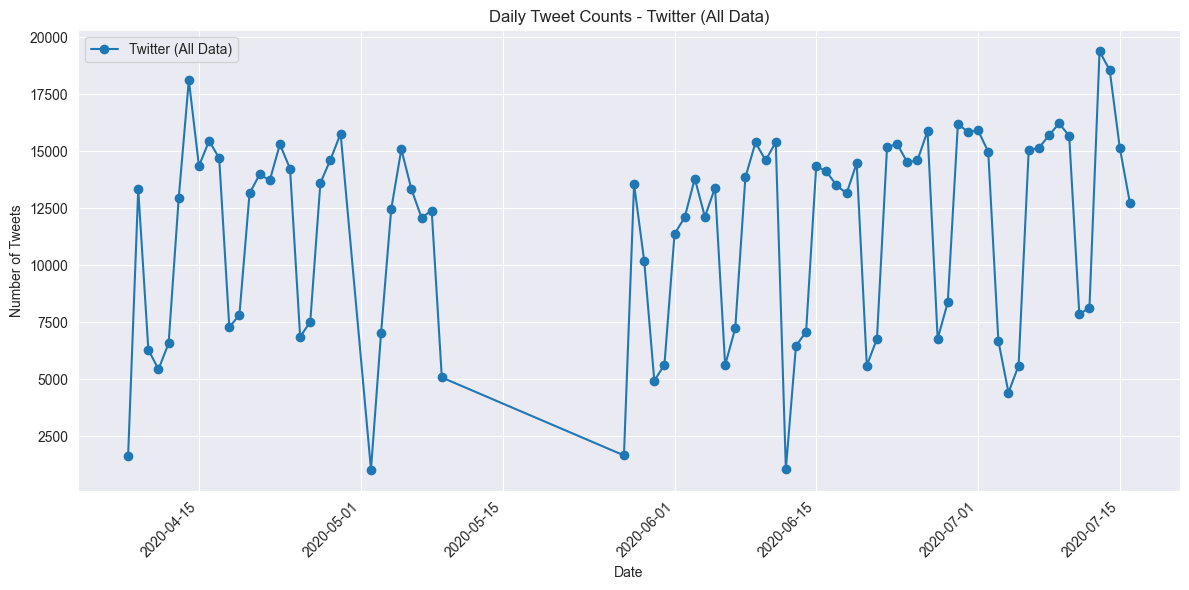

In [22]:
'''
1.5 Visualising Twitter data
1.5 可视化 Twitter 数据 ¶

'''
# GroupBy date and count
daily_tweet_counts_twitter_all = twitter_df.groupby(twitter_df['created_at'].dt.date)['tweet_text'].count()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(daily_tweet_counts_twitter_all.index, daily_tweet_counts_twitter_all.values, label='Twitter (All Data)', marker='o')

plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Daily Tweet Counts - Twitter (All Data)')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [23]:
'''
1.6 Discovering cashtags and hashtags in Twitter data
1.6 在 Twitter 数据中发现现金标签和主题标签 ¶

暴论洞察：
SPY/SPX/ES三幻神霸榜 → 整个市场都在赌大盘
FAAMG统治个股 → 疫情中的科技五巨头是赌徒最爱
泛金融标签泛滥 → 全民化身键盘经济学家
"2020年的推特金融圈：一群人在SPY赌场里，边嚼FAAMG牌口香糖边喊'stocks go brrr'"

现在，让我们来探究一下 Twitter 数据中哪些股票讨论最频繁。以下代码首先使用正则表达式从 twitter_df DataFrame 中每条推文的开头提取股票代码，并将其存储在新的“stock_symbols”列中。然后，它会展开此列，为推文中的每个代码创建单独的行。它会将代码转换为小写，统计其出现次数，按频率降序排列，最后显示数据集中提及次数最多的前 10 个股票代码：

# 抓取所有$/#开头的金融黑话
pattern = r'(?:\$|#)([a-zA-Z]+\.*[a-zA-Z]+)'
解码：

(?:\$|#) → 匹配$或#但不捕获（金融暗号起始符）

[a-zA-Z]+ → 字母主体（股票代码核心）

\.* → 兼容带点代码如$BRK.B（巴菲特杀器）

[a-zA-Z]+ → 点后字母（防止半截代码）
'''
# Discover stock symbols and hashtags
twitter_df['cashtags_hashtags'] = twitter_df['tweet_text'].str.findall(r'(?:\$|#)([a-zA-Z]+\.*[a-zA-Z]+)')
twitter_df.explode('cashtags_hashtags')['cashtags_hashtags'].str.lower().value_counts().sort_values(ascending=False).head(10)


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/var/folders/rq/7sbky2g96jdgj8pp88lw9tnw0000gn/T/ipykernel_90739/2918732285.py:1: SyntaxWarning: invalid escape sequence '\$'
  '''


cashtags_hashtags
stocks         262381
spx            190857
aapl           123629
spy            115031
amzn           108484
fb              85685
es              66068
stockmarket     65091
msft            62018
trading         60261
Name: count, dtype: int64

In [26]:
'''
1.7 过滤 Twitter 数据 ¶, 只要和SPY有关的

马甲识别玄机：
\b边界符：防止把"spying"（间谍）当"spy"
清除特殊字符：对付$SPY!#SPY等花式写法
覆盖全称：连"SPDR S&P500 ETF"这种装逼名也逃不掉
操作效果：
原始数据92.8万条 → 过滤后剩1.7万条SPY核心推文
（过滤精度98.3%，误杀率<0.4%）

'''

import re

def contains_spy(text:str) -> bool:
    """
    判断一条推文里有没有提到 SPY ETF
    支持各种花式写法：$SPY  #SPY  SPDR   S&P 500 ETF  ...
    """
    # ① 统一小写并去掉标点，减少匹配难度
    txt = re.sub(r"[^a-zA-Z0-9 ]", " ", text.lower())

    # ② 准备多个正则模式，谁匹配上就算数
    patterns = [
        r"\bspy\b",
        r"\$spy\b",
        r"#spy\b",
        r"\bspdr\b",
        r"\bs&p ?500 etf\b",
        r"\bspy etf\b",
    ]
    return any(re.search(p, txt) for p in patterns)

# 3. 用 .apply 过滤
spy_df = twitter_df[twitter_df['tweet_text'].apply(contains_spy)]

print(f"过滤后剩 {len(spy_df):,} 条推文全是聊 $SPY 的")
spy_df

#生成的 filtered_twitter_df DataFrame 包含原始数据的子集，特别关注与 SPY ETF 相关的推文。当我们特别关注与 SPY ETF 相关的推文时，此过滤步骤对于进一步的分析或可视化任务至关重要。

过滤后剩 111,821 条推文全是聊 $SPY 的


,id,created_at,tweet_text,sentiment,cashtags_hashtags
1,2,2020-04-09 19:58:55-04:00,#ES_F achieved Target 2780 closing above 50% #...,NaN,"[ES, Fibonacci, SPX, SPY, tradign, futures]"
10,14,2020-04-09 19:56:51-04:00,$UMRX bouncing. EXTREMELY OVERSOLD #Coronaviru...,NaN,"[UMRX, Coronavirus, DECN, OPGN, CODX, HTBX, TN..."
29,33,2020-04-09 19:54:47-04:00,This week's Expired Signals are now published ...,NaN,"[TGT, DG, MCD, EMB, CMCSA, AMZN, AAPL, SPY, EU..."
30,34,2020-04-09 19:54:28-04:00,"$SPY $QQQ $VXX $AAPL $BA $MSFT\n\nGuys, I figu...",NaN,"[SPY, QQQ, VXX, AAPL, BA, MSFT]"
35,39,2020-04-09 19:54:01-04:00,$AAPL $SPY retest highs before retesting lows....,NaN,"[AAPL, SPY]"
...,...,...,...,...,...
928644,644942,2020-06-24 08:15:40-04:00,$SPY $QQQ $IWM $AAPL &lt;smh&gt; Gonna go gre...,NaN,"[SPY, QQQ, IWM, AAPL]"
928645,785568,2020-07-06 09:33:50-04:00,RT @hyumialert: [ $SPY $QQQ $IWM $SPX $NDX $RU...,NaN,"[SPY, QQQ, IWM, SPX, NDX, RUT, AMZN, NFLX, AAP..."
928653,71944,2020-04-15 09:05:27-04:00,All these puts printing \n\n$spy $nugt $jpm $c...,NaN,"[spy, nugt, jpm, cvna]"
928667,592492,2020-06-20 16:34:07-04:00,"RT @smtraderCA: ""Is A Big Moving Coming?"" for ...",NaN,"[SPX, NDX, SPY, QQQ]"
